# Test 5

Entrenamiento de Mask R-CNN (master_matterport_v2) con dataset modificado para emular "Test 5"

### Hiperparametros
* **epoch = 300**
    * steps x epoch = 73 (lotes de 4 imagenes)
    * batch = 4 (lote)
* optimizador = SGD
* Funcion de perdida = SMOOTHL1LOSS
* Metrica de evaluacion = IOU
* Mini-mask shape: 56x56
* RPN anchor scales: (32, 64, 128, 256, 512)
* Tasa de aprendizaje: 0.001

#### Dataset
* imagenes = 292
    * entrenamiento 81% = 237
    * validacion 19% = 55
* etiquetas = 9140
* **resolucion = 1920 x 1080**
* etiquetas = bounding box formato XML
* numero de clases = 1 (arandano)
* **data augmentation = false**

#### Métricas
* mIoU = 0.394
* mAP(IoU >= 0.5) = 0.185
* mAP(IoU >= 0.7) = 0.179

## Cambiar de directorio principal

In [1]:
!pwd && ls

/tf/PT_JoseVeloso/Mask_RCNN-master_matterport/model-training
build  dist  mask_rcnn.egg-info  master-test_5-v2.ipynb  master.ipynb  mrcnn


# Importar bibliotecas

In [40]:
# bibliotecas basicas
import os
from os import listdir
import sys
import json
import datetime

#sys.path.append("/tf/PT_JoseVeloso/Mask_RCNN-master/")

# bibliotecas avanzadas 
from xml.etree import ElementTree
import skimage.draw
import cv2
import imgaug

# bibliotecas mask rcnn 
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn import visualize

# biblioteca matplotlib 
import matplotlib.pyplot as plt

# bibliotecas numpy 
import numpy as np
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean

# bibliotecas keras
from tensorflow.keras.preprocessing.image import load_img   #keras.preprocessing.image tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

# ignorar alertas de elementos que seran descontinuados
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline
#plt.show()

# Entrenamiento con una sola clase y etiquetas de Bounding Box

En este entremamiento se utiliza un conjunto de datos simple con imágenes etiquetadas con cuadros delimitadores y una clase llamada 'Daño'. En la siguiente sección se encuentra el código para el entrenamiento del modelo. Se incluyen comentarios para describir mejor el flujo del programa.

In [52]:
class DatasetArandanos(Dataset):
    
    # la funcion load_dataset es usada para cargar el dataset de entrenamiento y test
    def load_dataset(self, dataset_dir, is_train=True):
        
        # se agrega una clase que se necesita para clasificar, en este caso arandano
        self.add_class("dataset", 1, "arandano")
        
        # se concatena dataset_dir con /images y /annots
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        
        # is_train sera Verdadero si se esta entrenando el modelo y Falso si se esta testeando el modelo
        for filename in listdir(images_dir):
            
            # extraer image id
            image_id = filename[:-4] # se usa para omitir los últimos 4 caracteres: '.jpg' (en class_id.jpg)
            
            # si is_train es Verdadero se omiten todas las imágenes con id mayor que e iguales a 11074
            # aproximadamente el 80% del conjunto de datos es para entrenamiento
            
            if is_train and int(image_id) >= 11074 :
                print("image_id: ", image_id)
                continue
            
            # si is_train no es Verdadero se omiten todas las imágenes con id menores a 11074
            if not is_train and int(image_id) < 11074:
                continue
            
            # se declara la ruta de la imagen y la ruta de las etiquetas 
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            # usando la función add_image se pasan image_id, image_path y ann_path para que la 
            # imagen actual se agregue al conjunto de datos para entrenamiento o prueba
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # funcino usada para extraer bouding boxes desde archivos etiquetados 
    def extract_boxes(self, filename):

        # se puede ver en las imágenes que estan etiquetadas, como se extraen los valores de ancho, alto y bndbox
        
        # <annotation>
        # <size>

        #       <width>640</width>

        #       <height>360</height>

        #       <depth>3</depth>

        # </size>


        # <object>

        #          <name>damage</name>

        #          <pose>Unspecified</pose>

        #          <truncated>0</truncated>

        #          <difficult>0</difficult>


        #          <bndbox>

        #                 <xmin>315</xmin>

        #                 <ymin>160</ymin>

        #                 <xmax>381</xmax>

        #                 <ymax>199</ymax>

        #          </bndbox>

        # </object>
        # </annotation>
        
        # para analizar los archivos .xml
        tree = ElementTree.parse(filename)
        
        # para obtener la raíz del archivo xml
        root = tree.getroot()
        
        # se agregan todas las coordenadas x, y en boxes para todas las instancias de un objeto
        boxes = list()
        
        # se encuentran todos los atributos con el nombre bndbox que existan para cada ground truth en la imagen
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extraer ancho y alto de la imagen
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        
        # retorna boxes-> list, width-> int y height-> int 
        return boxes, width, height
    
    # this function calls on the extract_boxes method and is used to load a mask for each instance in an image
    # returns a boolean mask with following dimensions width * height * instances

    # esta función llama al método extract_boxes y se usa para cargar una máscara para cada instancia en una imagen 
    # devuelve una máscara booleana con las siguientes dimensiones ancho * alto * instancias
    def load_mask(self, image_id):
        
        # info apunta al image_id actual 
        info = self.image_info[image_id]
        
        # se obtiene la ruta de anotación de image_id que es dataset_dir/annots/image_id.xml 
        path = info['annotation']
        
        # se llama al método extract_boxes (arriba) para obtener bndbox del archivo .xml
        boxes, w, h = self.extract_boxes(path)
        
        # se crea una cantidad de len(boxes) de mascaras de alto 'h' y ancho 'w'
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # se agrega (append) el class_id 1 para arandano en nuestro caso a la variable
        class_ids = list()
        
        # se recorren todos los boxes y generamos máscaras (máscara de bndbox) y class id para cada instancia
        # las máscaras tendrán forma rectangular ya que hemos usado bndboxes para etiquetas
        # por ejemplo: si 2.jpg tiene tres objetos, tendremos las siguientes máscaras y class_ids.

        # 000000000 000000000 000001110 
        # 000011100 011100000 000001110
        # 000011100 011100000 000001110
        # 000000000 011100000 000000000
        #    1         1          1    <- class_ids
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('arandano'))
        
        # retorna mascaras y class_ids como arreglo
        return masks, asarray(class_ids, dtype='int32')
    
    # esta funciones toma el image_id y retorna la ruta de la imagen 
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# clase de configuracion arandano, aqui se pueden cambiar valores de hyper parameters 
class ConfigArandanos(Config):

    # nombre de la configuracion 
    NAME = "arandano_cfg_test_5_"    
    
    # clase arandano + clase background 
    NUM_CLASSES = 1 + 1
    
    # pasos por epoch y confianza minima    # STEPS_PER_EPOCH = cantidad de lotes/batchs
    #STEPS_PER_EPOCH = 73   # por epoch se entrenaran 73 lotes de 4 imagenes, dataset = 292
    STEPS_PER_EPOCH = 146
    
    # tasa de aprendizaje y momentum
    LEARNING_RATE=0.001
    LEARNING_MOMENTUM = 0.8
    
    # penalización de regularización
    WEIGHT_DECAY = 0.0001
    
    # el tamaño de la imagen está controlado por este parámetro
    IMAGE_MIN_DIM = 512
    
    # pasos de validación
    VALIDATION_STEPS = 50
    
    # número de regiones de interés generadas por imagen
    Train_ROIs_Per_Image = 200
    
    # escala de anclas RPN y proporciones (ratios) para encontrar la ROI
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)    # Longitud del lado del ancla cuadrada, en píxeles 
    RPN_ANCHOR_RATIOS = [0.5, 1, 1.5]   # Proporciones de anclas por cada celda (ancho/alto). Un valor de 1 representa un ancla cuadrada y 0,5 es un ancla ancha 

config = ConfigArandanos()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.8
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [6]:
# cargar dataset de entrenamiento
train_set = DatasetArandanos()
train_set.load_dataset('customImages/test_5_2', is_train=True)
train_set.prepare()

# cargar dataset de test 
test_set = DatasetArandanos()
test_set.load_dataset('customImages/test_5_2', is_train=False)
test_set.prepare()

# preparar la configuración llamando a la clase de configuración definida por el usuario
config = ConfigArandanos()

# definir el modelo
model = MaskRCNN(mode='training', model_dir='./', config=config)

# cargar pesos del modelo mscoco
weights_path = 'mask_rcnn_coco.h5'
#weights_path = 'mask_rcnn_damage_cfg_0049.h5'

# cargar los pesos del modelo
model.load_weights(weights_path, 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])


# start the training of model
# you can change epochs and layers (head or all)
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=300, layers='heads')
#model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='all')

image_id:  31102
image_id:  40099
image_id:  30377
image_id:  40414
image_id:  21130
image_id:  50469
image_id:  41732
image_id:  25544
image_id:  50458
image_id:  23863
image_id:  30990
image_id:  30470
image_id:  20318
image_id:  50440
image_id:  21295
image_id:  22345
image_id:  40390
image_id:  20782
image_id:  30676
image_id:  30000
image_id:  50135
image_id:  50912
image_id:  22783
image_id:  20150
image_id:  40346
image_id:  31246
image_id:  25750
image_id:  50983
image_id:  50607
image_id:  25690
image_id:  40999
image_id:  21150
image_id:  23719
image_id:  11117
image_id:  20425
image_id:  40253
image_id:  51082
image_id:  20250
image_id:  41406
image_id:  20585
image_id:  11076
image_id:  50393
image_id:  30851
image_id:  50958
image_id:  50857
image_id:  25640
image_id:  51057
image_id:  50710
image_id:  31284
image_id:  40213
image_id:  40960
image_id:  50386
image_id:  41762
image_id:  41383
image_id:  22536
image_id:  30502
image_id:  50269
image_id:  30958
image_id:  222

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/300


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_5:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape_1:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_2:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_8:0", shape=

146/146 [==============================] - 289s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 10.3548 - rpn_class_loss: 1.5790 - rpn_bbox_loss: 5.4410 - mrcnn_class_loss: 0.3182 - mrcnn_bbox_loss: 2.5659 - mrcnn_mask_loss: 0.4506 - val_loss: 6.2318 - val_rpn_class_loss: 1.7185 - val_rpn_bbox_loss: 2.7086 - val_mrcnn_class_loss: 0.2184 - val_mrcnn_bbox_loss: 1.1047 - val_mrcnn_mask_loss: 0.4816
Epoch 2/300
146/146 [==============================] - 238s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 3.1743 - rpn_class_loss: 0.3833 - rpn_bbox_loss: 1.2566 - mrcnn_class_loss: 0.3281 - mrcnn_bbox_loss: 0.7401 - mrcnn_mask_loss: 0.4662 - val_loss: 3.1950 - val_rpn_class_loss: 0.7795 - val_rpn_bbox_loss: 0.9201 - val_mrcnn_class_loss: 0.3485 - val_mrcnn_bbox_loss: 0.6817 - val_mrcnn_mask_loss: 0.4652
Epoch 3/300
146/146 [==============================] - 275s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 1.9879 - rpn_class_loss: 0.2455 - rpn_bbox_loss: 0.4560 - mrcnn_class_loss: 0.3627 

Epoch 21/300
146/146 [==============================] - 237s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.7039 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.0868 - mrcnn_class_loss: 0.1356 - mrcnn_bbox_loss: 0.1139 - mrcnn_mask_loss: 0.3198 - val_loss: 3.7047 - val_rpn_class_loss: 1.3331 - val_rpn_bbox_loss: 0.7408 - val_mrcnn_class_loss: 0.7662 - val_mrcnn_bbox_loss: 0.4875 - val_mrcnn_mask_loss: 0.3771
Epoch 22/300
146/146 [==============================] - 255s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.6889 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.3171 - val_loss: 3.4151 - val_rpn_class_loss: 1.1134 - val_rpn_bbox_loss: 0.6925 - val_mrcnn_class_loss: 0.7341 - val_mrcnn_bbox_loss: 0.4600 - val_mrcnn_mask_loss: 0.4150
Epoch 23/300
146/146 [==============================] - 257s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.6825 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.0858 - mrcnn_class

Epoch 41/300
146/146 [==============================] - 286s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.4426 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.0365 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.2720 - val_loss: 4.4212 - val_rpn_class_loss: 1.8502 - val_rpn_bbox_loss: 0.8031 - val_mrcnn_class_loss: 0.9432 - val_mrcnn_bbox_loss: 0.4209 - val_mrcnn_mask_loss: 0.4039
Epoch 42/300
146/146 [==============================] - 236s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.4408 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0388 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.2675 - val_loss: 4.3748 - val_rpn_class_loss: 1.6705 - val_rpn_bbox_loss: 0.6871 - val_mrcnn_class_loss: 1.1639 - val_mrcnn_bbox_loss: 0.4487 - val_mrcnn_mask_loss: 0.4047
Epoch 43/300
146/146 [==============================] - 246s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.4096 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.0322 - mrcnn_class

Epoch 61/300
146/146 [==============================] - 253s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.3373 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.0361 - mrcnn_mask_loss: 0.2239 - val_loss: 4.8757 - val_rpn_class_loss: 2.0211 - val_rpn_bbox_loss: 0.8155 - val_mrcnn_class_loss: 1.1465 - val_mrcnn_bbox_loss: 0.4434 - val_mrcnn_mask_loss: 0.4492
Epoch 62/300
146/146 [==============================] - 260s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.3188 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0198 - mrcnn_class_loss: 0.0364 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.2197 - val_loss: 4.8090 - val_rpn_class_loss: 1.9702 - val_rpn_bbox_loss: 0.8301 - val_mrcnn_class_loss: 1.1772 - val_mrcnn_bbox_loss: 0.4155 - val_mrcnn_mask_loss: 0.4160
Epoch 63/300
146/146 [==============================] - 253s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.3168 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0210 - mrcnn_class

Epoch 81/300
146/146 [==============================] - 263s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.2622 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.1866 - val_loss: 5.5733 - val_rpn_class_loss: 2.4122 - val_rpn_bbox_loss: 0.8608 - val_mrcnn_class_loss: 1.3828 - val_mrcnn_bbox_loss: 0.4390 - val_mrcnn_mask_loss: 0.4786
Epoch 82/300
146/146 [==============================] - 252s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.2604 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0149 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.1865 - val_loss: 5.6515 - val_rpn_class_loss: 2.4352 - val_rpn_bbox_loss: 0.8955 - val_mrcnn_class_loss: 1.4386 - val_mrcnn_bbox_loss: 0.4211 - val_mrcnn_mask_loss: 0.4610
Epoch 83/300
146/146 [==============================] - 255s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.2578 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.0155 - mrcnn_class

Epoch 101/300
146/146 [==============================] - 264s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.2156 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0116 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0188 - mrcnn_mask_loss: 0.1539 - val_loss: 5.8454 - val_rpn_class_loss: 2.5893 - val_rpn_bbox_loss: 0.8552 - val_mrcnn_class_loss: 1.4581 - val_mrcnn_bbox_loss: 0.4320 - val_mrcnn_mask_loss: 0.5107
Epoch 102/300
146/146 [==============================] - 270s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.2253 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0132 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.0198 - mrcnn_mask_loss: 0.1616 - val_loss: 6.1131 - val_rpn_class_loss: 2.7664 - val_rpn_bbox_loss: 0.8759 - val_mrcnn_class_loss: 1.5069 - val_mrcnn_bbox_loss: 0.4503 - val_mrcnn_mask_loss: 0.5136
Epoch 103/300
146/146 [==============================] - 268s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.2155 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0123 - mrcnn_cl

Epoch 121/300
146/146 [==============================] - 255s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1980 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0126 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.0179 - mrcnn_mask_loss: 0.1403 - val_loss: 6.8160 - val_rpn_class_loss: 3.3479 - val_rpn_bbox_loss: 0.9516 - val_mrcnn_class_loss: 1.5520 - val_mrcnn_bbox_loss: 0.4295 - val_mrcnn_mask_loss: 0.5350
Epoch 122/300
146/146 [==============================] - 240s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1885 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0115 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0167 - mrcnn_mask_loss: 0.1324 - val_loss: 6.6315 - val_rpn_class_loss: 3.1122 - val_rpn_bbox_loss: 0.8550 - val_mrcnn_class_loss: 1.6557 - val_mrcnn_bbox_loss: 0.4307 - val_mrcnn_mask_loss: 0.5778
Epoch 123/300
146/146 [==============================] - 252s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1959 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0121 - mrcnn_cl

Epoch 141/300
146/146 [==============================] - 260s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1654 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0085 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0133 - mrcnn_mask_loss: 0.1191 - val_loss: 6.6963 - val_rpn_class_loss: 2.9952 - val_rpn_bbox_loss: 0.8946 - val_mrcnn_class_loss: 1.7983 - val_mrcnn_bbox_loss: 0.4126 - val_mrcnn_mask_loss: 0.5957
Epoch 142/300
146/146 [==============================] - 270s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1696 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0095 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.1222 - val_loss: 6.4672 - val_rpn_class_loss: 3.0573 - val_rpn_bbox_loss: 0.9399 - val_mrcnn_class_loss: 1.4654 - val_mrcnn_bbox_loss: 0.4098 - val_mrcnn_mask_loss: 0.5948
Epoch 143/300
146/146 [==============================] - 266s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1503 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0068 - mrcnn_cl

Epoch 161/300
146/146 [==============================] - 252s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1384 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0061 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0097 - mrcnn_mask_loss: 0.1030 - val_loss: 6.1856 - val_rpn_class_loss: 2.6600 - val_rpn_bbox_loss: 0.9343 - val_mrcnn_class_loss: 1.5051 - val_mrcnn_bbox_loss: 0.4066 - val_mrcnn_mask_loss: 0.6796
Epoch 162/300
146/146 [==============================] - 264s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1333 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0059 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0099 - mrcnn_mask_loss: 0.0986 - val_loss: 7.3640 - val_rpn_class_loss: 3.4638 - val_rpn_bbox_loss: 0.9494 - val_mrcnn_class_loss: 1.7686 - val_mrcnn_bbox_loss: 0.4227 - val_mrcnn_mask_loss: 0.7596
Epoch 163/300
146/146 [==============================] - 252s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1428 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0072 - mrcnn_cl

Epoch 181/300
146/146 [==============================] - 286s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1284 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0059 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0095 - mrcnn_mask_loss: 0.0950 - val_loss: 6.9398 - val_rpn_class_loss: 3.2989 - val_rpn_bbox_loss: 0.9821 - val_mrcnn_class_loss: 1.6085 - val_mrcnn_bbox_loss: 0.4029 - val_mrcnn_mask_loss: 0.6474
Epoch 182/300
146/146 [==============================] - 330s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1341 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0066 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0102 - mrcnn_mask_loss: 0.0960 - val_loss: 7.2048 - val_rpn_class_loss: 3.5046 - val_rpn_bbox_loss: 0.8901 - val_mrcnn_class_loss: 1.6618 - val_mrcnn_bbox_loss: 0.4262 - val_mrcnn_mask_loss: 0.7221
Epoch 183/300
146/146 [==============================] - 262s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1240 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0061 - mrcnn_cl

Epoch 201/300
146/146 [==============================] - 300s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1216 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0062 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0089 - mrcnn_mask_loss: 0.0895 - val_loss: 7.5686 - val_rpn_class_loss: 3.6171 - val_rpn_bbox_loss: 0.9995 - val_mrcnn_class_loss: 1.7576 - val_mrcnn_bbox_loss: 0.4405 - val_mrcnn_mask_loss: 0.7539
Epoch 202/300
146/146 [==============================] - 292s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1304 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0071 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0105 - mrcnn_mask_loss: 0.0944 - val_loss: 7.5553 - val_rpn_class_loss: 3.4914 - val_rpn_bbox_loss: 0.8761 - val_mrcnn_class_loss: 2.0049 - val_mrcnn_bbox_loss: 0.4326 - val_mrcnn_mask_loss: 0.7502
Epoch 203/300
146/146 [==============================] - 310s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1185 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0055 - mrcnn_cl

Epoch 221/300
146/146 [==============================] - 297s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1123 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0054 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0083 - mrcnn_mask_loss: 0.0830 - val_loss: 7.9618 - val_rpn_class_loss: 3.7073 - val_rpn_bbox_loss: 1.0596 - val_mrcnn_class_loss: 1.8452 - val_mrcnn_bbox_loss: 0.4311 - val_mrcnn_mask_loss: 0.9186
Epoch 222/300
146/146 [==============================] - 297s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1134 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0055 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0086 - mrcnn_mask_loss: 0.0825 - val_loss: 7.8177 - val_rpn_class_loss: 3.7738 - val_rpn_bbox_loss: 1.0247 - val_mrcnn_class_loss: 1.8640 - val_mrcnn_bbox_loss: 0.4198 - val_mrcnn_mask_loss: 0.7354
Epoch 223/300
146/146 [==============================] - 303s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1156 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0058 - mrcnn_cl

Epoch 241/300
146/146 [==============================] - 319s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1032 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0046 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.0756 - val_loss: 7.8924 - val_rpn_class_loss: 3.8819 - val_rpn_bbox_loss: 0.9918 - val_mrcnn_class_loss: 1.7642 - val_mrcnn_bbox_loss: 0.4116 - val_mrcnn_mask_loss: 0.8430
Epoch 242/300
146/146 [==============================] - 282s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1013 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0042 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.0752 - val_loss: 7.2448 - val_rpn_class_loss: 3.4425 - val_rpn_bbox_loss: 0.9785 - val_mrcnn_class_loss: 1.6411 - val_mrcnn_bbox_loss: 0.3902 - val_mrcnn_mask_loss: 0.7925
Epoch 243/300
146/146 [==============================] - 302s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.1020 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0047 - mrcnn_cl

Epoch 261/300
146/146 [==============================] - 280s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.0935 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0040 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0064 - mrcnn_mask_loss: 0.0696 - val_loss: 7.7431 - val_rpn_class_loss: 3.8521 - val_rpn_bbox_loss: 0.9963 - val_mrcnn_class_loss: 1.6625 - val_mrcnn_bbox_loss: 0.4111 - val_mrcnn_mask_loss: 0.8211
Epoch 262/300
146/146 [==============================] - 315s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.0941 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0038 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0060 - mrcnn_mask_loss: 0.0714 - val_loss: 8.1408 - val_rpn_class_loss: 3.8382 - val_rpn_bbox_loss: 0.9841 - val_mrcnn_class_loss: 2.0396 - val_mrcnn_bbox_loss: 0.4274 - val_mrcnn_mask_loss: 0.8516
Epoch 263/300
146/146 [==============================] - 275s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.0909 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0036 - mrcnn_cl

Epoch 281/300
146/146 [==============================] - 256s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.0971 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0049 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0069 - mrcnn_mask_loss: 0.0719 - val_loss: 7.7071 - val_rpn_class_loss: 3.5832 - val_rpn_bbox_loss: 1.0062 - val_mrcnn_class_loss: 1.8199 - val_mrcnn_bbox_loss: 0.4108 - val_mrcnn_mask_loss: 0.8871
Epoch 282/300
146/146 [==============================] - 239s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.0908 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0038 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0061 - mrcnn_mask_loss: 0.0681 - val_loss: 8.3704 - val_rpn_class_loss: 4.1893 - val_rpn_bbox_loss: 1.0302 - val_mrcnn_class_loss: 1.9018 - val_mrcnn_bbox_loss: 0.4061 - val_mrcnn_mask_loss: 0.8430
Epoch 283/300
146/146 [==============================] - 275s 2s/step - batch: 72.5000 - size: 2.0000 - loss: 0.0939 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0044 - mrcnn_cl

In [4]:
cd /tf/PT_JoseVeloso/Mask_RCNN-master_matterport/

/tf/PT_JoseVeloso/Mask_RCNN-master_matterport


In [ ]:
# cargar dataset de entrenamiento
train_set = DatasetArandanos()
train_set.load_dataset('customImages/test_5_2', is_train=True)
train_set.prepare()

# cargar dataset de test 
test_set = DatasetArandanos()
test_set.load_dataset('customImages/test_5_2', is_train=False)
test_set.prepare()

# preparar la configuración llamando a la clase de configuración definida por el usuario
config = ConfigArandanos()

# definir el modelo
model = MaskRCNN(mode='training', model_dir='./', config=config)

# cargar pesos del modelo mscoco
weights_path = 'mask_rcnn_coco.h5'
#weights_path = 'mask_rcnn_damage_cfg_0049.h5'

# cargar los pesos del modelo
model.load_weights(weights_path, 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])


# start the training of model
# you can change epochs and layers (head or all)
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=100, layers='heads')
#model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='all')

# Fase 2 - Entrenamiento con dos clases y etiquetas de Bounding Box

In [ ]:
In the stage I trained the model on multiple classes namely level-1 (scratch), level-2 (dent), level-3 (shatter), and level-4 (dislocation). The images are annotated using bounding boxes.

I recommend going through Stag-1 Training code first, there is not much difference between code of stage 1 and stage 2.

## Model Training

In [ ]:
class DamageDataset(Dataset):

    # load_dataset function is used to load the train and test dataset
    def load_dataset(self, dataset_dir, is_train=True):
        
        # we use add_class for each class in our dataset and assign numbers to them. 0 is background
        # self.add_class('source', 'class id', 'class name')
        self.add_class("dataset", 1, "Level-1")
        self.add_class("dataset", 2, "Level-2")
        self.add_class("dataset", 3, "Level-3")
        self.add_class("dataset", 4, "Level-4")
        
        # we concatenate the dataset_dir with /images and /annots
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        
        # is_train will be true if we our training our model and false when we are testing the model
        for filename in listdir(images_dir):
            
            # extract image id
            image_id = filename[:-4] # used to skip last 4 chars which is '.jpg' (class_id.jpg)
            
            # if is_train is True skip all images with id greater than and equal to 160
             # roughly 80% of dataset for training
            if is_train and int(image_id) >= 160 :
                continue
             
            # if is_train is not True skip all images with id less than 420
            if not is_train and int(image_id) < 160:
                continue
            
            # img_path and ann_path variables are defined
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            
            # using add_image function we pass image_id, image_path and ann_path so that the current
            # image is added to the dataset for training
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    
    # function used to extract bouding boxes from annotated files
    def extract_boxes(self, filename):

        # you can see how the images are annotated we extracrt the width, height and bndbox values

        # <size>

        #       <width>640</width>

        #       <height>360</height>

        #       <depth>3</depth>

        # </size>


        # <object>

        #          <name>damage</name>

        #          <pose>Unspecified</pose>

        #          <truncated>0</truncated>

        #          <difficult>0</difficult>


        #          <bndbox>

        #                 <xmin>315</xmin>

        #                 <ymin>160</ymin>

        #                 <xmax>381</xmax>

        #                 <ymax>199</ymax>

        #          </bndbox>

        # </object>

        # </annotation>
        
        # used to parse the .xml files
        tree = ElementTree.parse(filename)
        
        # to get the root of the xml file
        root = tree.getroot()
        
        # we will append all x, y coordinated in boxes
        # for all instances of an onject
        boxes = list()
        
        # we find all attributes with name bndbox
        # bndbox will exist for each ground truth in an image
        for box in root.findall('.//object'):
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin, ymin, xmax, ymax, name]
            boxes.append(coors)
            
            # I have included this line to skip any un-annotated images
            if name=='Level-1' or name=='Level-2' or name=='Level-3' or name=='Level-4':
                boxes.append(coors)

        # extract width and height of the image
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        
        # return boxes-> list, width-> int and height-> int 
        return boxes, width, height
    
    # this function calls on the extract_boxes method and is used to load a mask for each instance in an image
    # returns a boolean mask with following dimensions width * height * instances        
    def load_mask(self, image_id):
        
        # info points to the current image_id
        info = self.image_info[image_id]
        
        # we get the annotation path of image_id which is dataset_dir/annots/image_id.xml
        path = info['annotation']
        
        # we call the extract_boxes method(above) to get bndbox from .xml file
        boxes, w, h = self.extract_boxes(path)
        
        # we create len(boxes) number of masks of height 'h' and width 'w'
        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        
        # we loop over all boxes and generate masks (bndbox mask) and class id for each instance
        # masks will have rectange shape as we have used bndboxes for annotations
        # for example: if 2.jpg have four objects we will have following masks and class_ids
        # 000000000 000000000 000003330 111100000
        # 000011100 022200000 000003330 111100000
        # 000011100 022200000 000003330 111100000
        # 000000000 022200000 000000000 000000000
        #    1         2          3         1<- class_ids
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            
            # box[4] will have the name of the class for a particular damage
            if (box[4] == 'Level-1'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('Level-1'))
            elif(box[4] == 'Level-2'):
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('Level-2')) 
            elif(box[4] == 'Level-3'):
                masks[row_s:row_e, col_s:col_e, i] = 3
                class_ids.append(self.class_names.index('Level-3'))
            else:
                masks[row_s:row_e, col_s:col_e, i] = 4
                class_ids.append(self.class_names.index('Level-4'))
                
        # return masks and class_ids as array
        return masks, asarray(class_ids, dtype='int32')
    
    # this functions takes the image_id and returns the path of the image
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# damage configuration class, you can change values of hyper parameters here
class DamageConfig(Config):
    # name of the configuration
    NAME = "damage_cfg"
    
    #  background class + 4 classes
    NUM_CLASSES = 1 + 4
    
    # steps per epoch and minimum confidence
    STEPS_PER_EPOCH = 160
    
    # learning rate and momentum
    LEARNING_RATE=0.002
    LEARNING_MOMENTUM = 0.8
    
    # regularization penalty
    WEIGHT_DECAY = 0.0001
    
    # image size is controlled by this parameter
    IMAGE_MIN_DIM = 512
    
    # validation steps
    VALIDATION_STEPS = 50
    
    # number of Region of Interest generated per image
    Train_ROIs_Per_Image = 200
    
    # RPN Acnhor scales and ratios to find ROI
    RPN_ANCHOR_SCALES = (16, 32, 48, 64, 128)
    RPN_ANCHOR_RATIOS = [0.5, 1, 1.5]

# prepare train set
train_set = DamageDataset()
train_set.load_dataset('customImages/stage-2', is_train=True)
train_set.prepare()

# validation/test
test_set = DamageDataset()
test_set.load_dataset('customImages/stage-2', is_train=False)
test_set.prepare()

# load damage config
config = DamageConfig()

# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)

# load weights mscoco model weights
weights_path = 'mask_rcnn_coco.h5'

# load the model weights
model.load_weights(weights_path, 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])


# start the training of model
# you can change epochs and layers (head or all)
model.train(train_set, 
            test_set, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')

# Evaluación del modelo - Fase 1

In [45]:
# se define una configuración de predicción 
class PredictionConfig(Config):
    NAME = "arandano"
    #NUM_CLASSES = 1 + 4
    NUM_CLASSES = 1 + 1
    
    #DETECTION_MIN_CONFIDENCE = 0.85
    DETECTION_MIN_CONFIDENCE = 0.7    
    
    IMAGE_MIN_DIM = 512
    LEARNING_MOMENTUM = 0.8
    RPN_ANCHOR_RATIOS = [0.5, 1, 1.5]
    STEPS_PER_EPOCH = 146
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK=False
    #USE_MINI_MASK=True    

cfg = PredictionConfig()
cfg.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.8
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [46]:
# evaluate_model se utiliza para calcular mean Average Precision del modelo
def evaluate_model(dataset, model, cfg):
    
    APs = list()
    '''
    Ps = list()
    Rs = list()     
    Os = list()     
    '''
    for image_id in dataset.image_ids:
        
        #image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id)
        
        scaled_image = mold_image(image, cfg)

        sample = expand_dims(scaled_image, 0)

        yhat = model.detect(sample, verbose=0)

        r = yhat[0]

        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        #AP, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        
        APs.append(AP)
        '''
        Ps.append(precisions)
        Rs.append(recalls)        
        Os.append(overlaps)        
        '''
        maP = mean(APs)
        '''
        mPs = mean(Ps)
        mRs = mean(Rs)
        mOs = mean(Os)
        '''
    #return maP, mPs, mRs, mOs
    return maP

# dataset entrenamiento
train_set = DatasetArandanos()

#train_set.load_dataset("customImages/stage-3", "train")
train_set.load_dataset("customImages/test_5_2", "train")
train_set.prepare()

# dataset validacion
test_set = DatasetArandanos()

#test_set.load_dataset("customImages/stage-3", "val")
test_set.load_dataset("customImages/test_5_2", "val")
test_set.prepare()

# crear config
cfg = PredictionConfig()

# definir el modelo
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

# cargar pesos del modelo
#model.load_weights('your_trained_model_weights.h5', by_name=True) ############################################ 
#model.load_weights('mask_rcnn_coco.h5', by_name=True)
#model.load_weights('arandano_cfg20220907T0914/mask_rcnn_arandano_cfg_0300.h5', by_name=True)
model.load_weights('arandano_cfg20220909T0812/mask_rcnn_arandano_cfg_0100.h5', by_name=True)

# evaluar el modelo en el conjunto de datos de entrenamiento
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)

# evaluar el modelo en el conjunto de datos de prueba
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

'''
# evaluar el modelo en el conjunto de datos de entrenamiento
train_mAP, train_mPs, train_mRs, train_mOs  = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
print("Train mPs: %.3f" % train_mPs)
print("Train mRs: %.3f" % train_mRs)
print("Train mOs: %.3f" % train_mOs)

# evaluar el modelo en el conjunto de datos de prueba
test_mAP, test_mPs, test_mRs, test_mOs = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)
print("Test mPs: %.3f" % test_mPs)
print("Test mRs: %.3f" % test_mRs)
print("Test mOs: %.3f" % test_mOs)
'''

image_id:  31102
image_id:  40099
image_id:  30377
image_id:  40414
image_id:  21130
image_id:  50469
image_id:  41732
image_id:  25544
image_id:  50458
image_id:  23863
image_id:  30990
image_id:  30470
image_id:  20318
image_id:  50440
image_id:  21295
image_id:  22345
image_id:  40390
image_id:  20782
image_id:  30676
image_id:  30000
image_id:  50135
image_id:  50912
image_id:  22783
image_id:  20150
image_id:  40346
image_id:  31246
image_id:  25750
image_id:  50983
image_id:  50607
image_id:  25690
image_id:  40999
image_id:  21150
image_id:  23719
image_id:  11117
image_id:  20425
image_id:  40253
image_id:  51082
image_id:  20250
image_id:  41406
image_id:  20585
image_id:  11076
image_id:  50393
image_id:  30851
image_id:  50958
image_id:  50857
image_id:  25640
image_id:  51057
image_id:  50710
image_id:  31284
image_id:  40213
image_id:  40960
image_id:  50386
image_id:  41762
image_id:  41383
image_id:  22536
image_id:  30502
image_id:  50269
image_id:  30958
image_id:  222

'\n# evaluar el modelo en el conjunto de datos de entrenamiento\ntrain_mAP, train_mPs, train_mRs, train_mOs  = evaluate_model(train_set, model, cfg)\nprint("Train mAP: %.3f" % train_mAP)\nprint("Train mPs: %.3f" % train_mPs)\nprint("Train mRs: %.3f" % train_mRs)\nprint("Train mOs: %.3f" % train_mOs)\n\n# evaluar el modelo en el conjunto de datos de prueba\ntest_mAP, test_mPs, test_mRs, test_mOs = evaluate_model(test_set, model, cfg)\nprint("Test mAP: %.3f" % test_mAP)\nprint("Test mPs: %.3f" % test_mPs)\nprint("Test mRs: %.3f" % test_mRs)\nprint("Test mOs: %.3f" % test_mOs)\n'

# Prediccion de imagen unica

In [47]:
# definir una configuración para el modelo
class PredictionConfig(Config):
    # definir el nombre de la configuración
    NAME = "arandano_pred"
    
    # número de clases (background + kangaroo)
    #NUM_CLASSES = 1 + 4
    NUM_CLASSES = 1 + 1
    
    # número de pasos de entrenamiento por epoch
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #USE_MINI_MASK=False
    USE_MINI_MASK=True 
    

    
    #DETECTION_MIN_CONFIDENCE = 0.85
    DETECTION_MIN_CONFIDENCE = 0.7     
    IMAGE_MIN_DIM = 512
    LEARNING_MOMENTUM = 0.8
    RPN_ANCHOR_RATIOS = [0.5, 1, 1.5]
    STEPS_PER_EPOCH = 146


In [48]:
# cargar configuración de predicción
cfg = PredictionConfig()

# definir el modelo
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

# cargar pesos del modelo
#model_path = 'arandano_cfg20220907T0914/mask_rcnn_arandano_cfg_0300.h5'    #########################################################
model_path = 'arandano_cfg20220909T0812/mask_rcnn_arandano_cfg_0100.h5'    #########################################################

model.load_weights(model_path, by_name=True)

Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


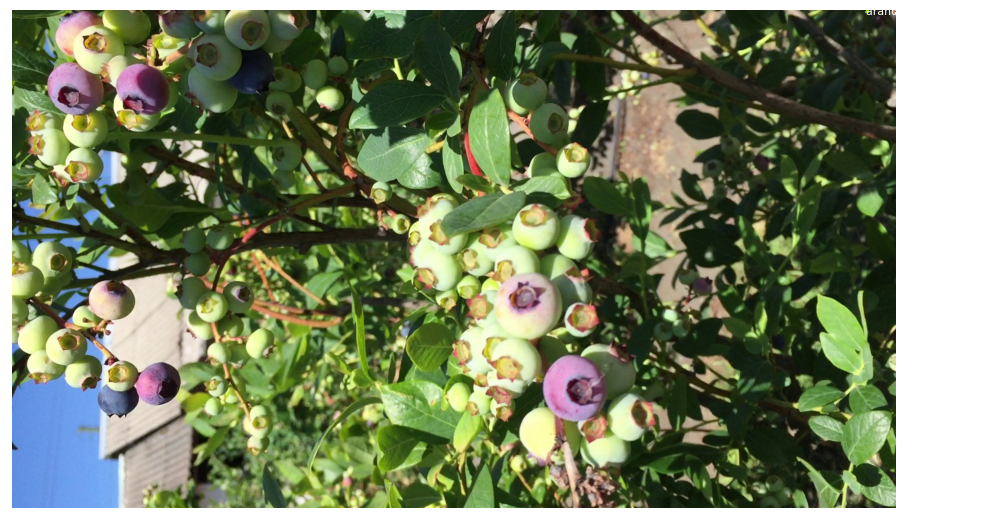

In [49]:
#image = load_img("image_path.jpg")
image = load_img("customImages/test_5_2/images/21050.jpg")
image = img_to_array(image)

results = model.detect([image], verbose=1)

#class_names = ['BG', 'Scratch', 'Dent', 'Shatter', 'Dislocation']
#class_names = ['BG', 'arandano', 'arandano2', 'arandano3', 'arandano4']
#class_names = ['arandano', 'BG']
class_names = ['BG', 'arandano']

r = results[0]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names,  r['scores'])

In [50]:
r 

{'rois': array([[   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1856,    1, 1860],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
        [   0, 1919,    1, 1920],
      